In [1]:
import numpy as np
import cmath as cm

from scipy.fft import fft,fftfreq
from scipy.interpolate import make_smoothing_spline

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from IPython.display import clear_output

import copy
from timeit import default_timer as timer
import pandas as pd

np.random.seed(2024061) # For reproducibility

import import_ipynb
from WavesPlasma import *

Nx     = 2100
p0plas = 90
k00    = 0.025
ν      = 84 
wpe2_,wc_ = freq_dicts(Nx,k00,p0plas)
# Profile reconstruction
β      = 27.9

importing Jupyter notebook from WavesPlasma.ipynb


<h3>Recovering the time of flight from the WEST simulations</h3>

In [2]:
Δt_Δx = k00/(2*np.pi*84) # ns per point

Additionally, to compare to Roland's plot, we need to obtain the list of cut-off positions for the given frequencies. That is as easy as determining for which index point the upper cut-off frequency coincides with the probing frequency.

In [3]:
ne0      = 5e5  # (1e14) m^{-3}
neped    = 1e5  # (1e14) m^{-3}
neoffset = 1    # (1e14) m^{-3}
nefactor = 1e14

R0  = 2.5     # meters
a   = 0.5     # meters
wth = 0.05    # adim

def ρ(R):
    return ((R-R0)/a)

# -- Plasma frequency --

def plasmaDensity_Roland(ρ):
    if ρ<=1: return ((ne0-neped)*(1-ρ**2)+neped)/(1+np.exp(-4*(1-ρ**2)/wth))
    else: return neped/(1+np.exp(-4*(1-ρ**2)/wth))+neoffset

def plasmaDensity_Parabolic(ρ):
    if np.abs(ρ)<1: return ne0*np.sqrt(1-ρ**2)
    else: return 0

e_ε0me = 3182.607355
e_me   = 1.7588201e11

def wpe2_WEST(ρ):
    return e_ε0me*plasmaDensity_Roland(ρ)*nefactor*1e-18/(2*np.pi*ν/k00)**2

def wpe2_Parabolic(ρ):
    return e_ε0me*plasmaDensity_Parabolic(ρ)*nefactor*1e-18/(2*np.pi*ν/k00)**2

# -- Cyclotron frequency --

def B_WEST(ρ):
    return 3.7*R0/(R0+0.5*ρ) #111/(-5+14*(R0+ρ*a))

def wc_WEST(ρ):
    return e_me*1e-9*B_WEST(ρ)/(2*np.pi*ν/k00)

# ----- 

def env_tanh(x):
    return 0.5*(np.tanh((x-1000)/400)+1)

# ----- 

ΔR_Δx = 1.420043e-5

def Rfromx(x):
    return 3.07-ΔR_Δx*(x-p0plas)

# ----- 

def wco_up(wpe2,wc):
    return 0.5*(wc+np.sqrt(wc**2+4*wpe2))
def wco_low(wpe2,wc):
    return 0.5*(-wc+np.sqrt(wc**2+4*wpe2))

<h4>Some plots</h4>

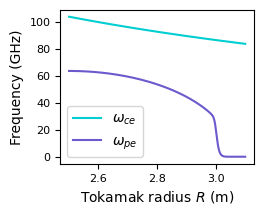

In [4]:
saveplots=0

fig,ax = plt.subplots(figsize=(2.5,2))

R_=np.linspace(2.5,3.1,1100)

ax.plot(R_,np.array([wc_WEST(ρ(R)) for R in R_])*ν/k00,label='$ω_{ce}$',c='darkturquoise') # remove *νrel for points^{-1}
ax.plot(R_,np.sqrt([wpe2_WEST(ρ(R)) for R in R_])*ν/k00,label='$ω_{pe}$',c='slateblue') # remove *νrel for points^{-1}

ax.set_xlabel('Tokamak radius $R$ (m)')
ax.set_ylabel('Frequency (GHz)')
ax.tick_params(axis='x',labelsize=8)
ax.tick_params(axis='y',labelsize=8)
#ax.invert_xaxis()

ax.legend()

if saveplots: plt.savefig(folderpath+'WESTcavity_introSlide.png',bbox_inches='tight',transparent=True,dpi=500)

plt.show()

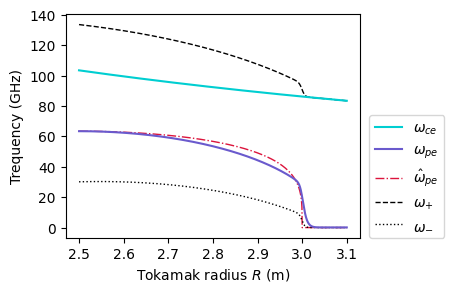

In [5]:
saveplots=0

fig,ax = plt.subplots(figsize=(3.8,2.9))

R_=np.linspace(2.5,3.1,1100)

ax.plot(R_,np.array([wc_WEST(ρ(R)) for R in R_])*ν/k00,label='$ω_{ce}$',c='darkturquoise') # remove *νrel for points^{-1}
ax.plot(R_,np.sqrt([wpe2_WEST(ρ(R)) for R in R_])*ν/k00,label='$ω_{pe}$',c='slateblue') # remove *νrel for points^{-1}
ax.plot(R_,np.sqrt([wpe2_Parabolic(ρ(R)) for R in R_])*ν/k00,label='$\hat{ω}_{pe}$',linestyle='-.',linewidth=1,c='crimson',zorder=0) # remove *νrel for points^{-1}

ax.plot(np.linspace(2.5,3.1,1100),np.array([wco_up(wpe2_WEST(ρ(R)),wc_WEST(ρ(R))) for R in np.linspace(2.5,3.1,1100)])*ν/k00,linestyle='dashed',linewidth=1,c='black',label='$ω_{+}$',zorder=1)
ax.plot(np.linspace(2.5,3.1,1100),np.array([wco_low(wpe2_WEST(ρ(R)),wc_WEST(ρ(R))) for R in np.linspace(2.5,3.1,1100)])*ν/k00,linestyle='dotted',linewidth=1,c='black',label='$ω_{-}$',zorder=1)

ax.set_xlabel('Tokamak radius $R$ (m)')
ax.set_ylabel('Trequency (GHz)')
#plt.ylabel('Frequency (points$^{-1}$)')
#ax.add_patch(Rectangle((Rfromx(Nx),-10),(Rfromx(0)-Rfromx(Nx)),200,color='red',alpha=0.05))
#ax.set_ylim(-5,110)
ax.legend(loc=(1.03,0))

if saveplots: plt.savefig(folderpath+'cavity_plot.png',bbox_inches='tight',transparent=True,dpi=500)

plt.show()

<h3>Recovering simulation data</h3>

In [6]:
folderpath = 'Results/WEST/'
filenameMtanh  = 'WESTmtanhProfile_FlightTime.pickle'
filenameParab = 'WESTParabolicProfile_FlightTime.pickle'

In [7]:
df = pd.read_pickle(folderpath+filenameMtanh)
try: df = df.drop(0)
except: pass
df

,Rc,probFrec (points),Source,Reflected,Transmitted,KineticTime
1,2.800,0.034823,"[0.0, 1.297693733821876e-07, 2.594293247517943...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,2.920,0.031351,"[0.0, 1.1683525919963274e-07, 2.33594539418395...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,2.980,0.029080,"[0.0, 1.0837082798412476e-07, 2.16683447139346...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,2.990,0.028553,"[0.0, 1.0641042300090927e-07, 2.12766322855227...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.05...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
5,2.997,0.027667,"[0.0, 1.0310860710209136e-07, 2.06168550318788...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
6,3.000,0.027009,"[0.0, 1.0065705579416519e-07, 2.01269523174019...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
7,3.003,0.026409,"[0.0, 9.841958911585324e-08, 1.967981109219845...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
8,3.010,0.025708,"[0.0, 9.580632387446383e-08, 1.915754598105128...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
9,3.015,0.025581,"[0.0, 9.53340458440407e-08, 1.906315786018151e...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
10,3.030,0.025433,"[0.0, 9.478400273844834e-08, 1.895322683851012...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [8]:
dfParab = pd.read_pickle(folderpath+filenameParab)
try: dfParab = dfParab.drop(0)
except: pass
dfParab

,Rc,probFrec (points),Source,Reflected,Transmitted,KineticTime
1,2.800000,0.035556,"[0.0, 1.325008600958835e-07, 2.648841886873498...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,2.920000,0.032375,"[0.0, 1.2065028978253123e-07, 2.41215557628258...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0587911...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,2.980000,0.029275,"[0.0, 1.0909858872294845e-07, 2.18137560313530...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.05...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,2.990000,0.028285,"[0.0, 1.0541147369417107e-07, 2.10770242566266...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
5,2.996616,0.027239,"[0.0, 1.0151206326917667e-07, 2.02978142882836...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
6,2.999000,0.026546,"[0.0, 9.893125299848875e-08, 1.978206499197118...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
7,2.999900,0.025963,"[0.0, 9.675914860484685e-08, 1.934797234625588...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


<h3>Recovering the WKB predicitions from R. Sabot</h3>

In [9]:
profileMtanhName  = 'tau_mtanh_profile.txt'
profileParabName = 'tau_parabolic_profile.txt'

def read_RSabotFile(profilename):
    with open(folderpath+profilename,'r') as file:
        Sstr = file.read()
    Sstr_ = Sstr.split('\n')
    data = [float(s) for s in Sstr_[:-1]]
    return np.array([data[:len(data)//2],data[len(data)//2:]])

profileMtanh  = read_RSabotFile(profileMtanhName)
profileParab = read_RSabotFile(profileParabName)

<h3>Computing the time of flight</h3>

We fistly compute the time of flight from the simulation. Note that this time accounts for the time-of-flight to and from the diagnostic. Recall that the source is placed at ```sPos=p0plas-10``` and the detector at ```sPos-2```.

In [10]:
τfast_=[]
for i in range(1,len(df)+1):
    try: τfast_.append(time_of_flight(df.loc[i].at['Source'],df.loc[i].at['Reflected'],(True,False),Fast=True))
    except: τfast_.append(0)
    
τfast_Parab=[]
for i in range(1,len(dfParab)+1):
    try: τfast_Parab.append(time_of_flight(dfParab.loc[i].at['Source'],dfParab.loc[i].at['Reflected'],(True,False),Fast=True))
    except: τfast_Parab.append(0)
    
# In points - to be multiplied by Δt_Δx to obtain nanoseconds
corrτ_Parab = -22 
corrτ_mtanh  = -22+2*0.03/ΔR_Δx # This 0.03 corresponds to 3.1 m (ToF reference for R. Sabot's WKB prediction) minus the 3.07 m that we chose to begin the mtanh domain.
τfast_ = np.array(τfast_)+corrτ_mtanh
τfast_Parab = np.array(τfast_Parab)+corrτ_Parab

Further notes on the corrections above:

- In the parabolic case the diagnostic was placed exactly at $R=3$m. Thus, we only need to correct the 22 points from our detector placement.

- In the mtanh profile case, as computed by S. Heuraux the contribution to the time of flight of the offset plasma density was negligible. Therefore we compute it as 3 cm of vacuum.

In [11]:
Rc_ = np.array(df['Rc'])
Rc_Parab = np.array(dfParab['Rc'])

In [12]:
for i in range(len(dfParab)):
    print('%.4f\t%.8f'%(Rc_Parab[i],τfast_Parab[i]))

2.8000	181835.10502127
2.9200	88107.41868669
2.9800	33633.92283321
2.9900	22227.39775630
2.9966	10798.56953731
2.9990	5044.05287075
2.9999	6357.20689259


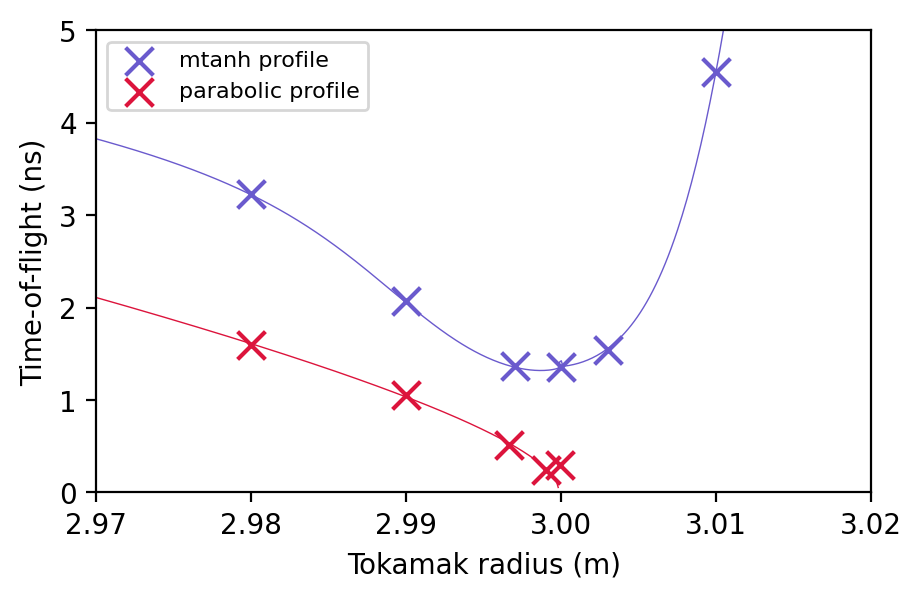

In [13]:
fig,ax = plt.subplots(figsize=(5,3),dpi=200)

#img = plt.imread('tau_ini_mtanh.png')
#imgGraph = [[39,467],[121,845]]
#ax.imshow(img[imgGraph[0][0]:imgGraph[0][1],imgGraph[1][0]:imgGraph[1][1]], extent=[2.5,3.1,0,25], aspect='auto',alpha=0.1)

ax.scatter(Rc_[:len(df)],np.array(τfast_)[:len(df)]*Δt_Δx,marker='x',c='slateblue',s=100,label='mtanh profile',zorder=4)
ax.scatter(Rc_Parab[:len(dfParab)],(np.array(τfast_Parab)[:len(dfParab)])*Δt_Δx,marker='x',c='crimson',s=100,label='parabolic profile',zorder=3) #corrτ_parab

ax.plot(profileMtanh[0],profileMtanh[1]*1e9,c='slateblue',linewidth=0.5,zorder=2)
ax.plot(profileParab[0],profileParab[1]*1e9,c='crimson',linewidth=0.5,zorder=1)

ax.set_ylabel('Time-of-flight (ns)')
ax.set_xlabel('Tokamak radius (m)')

#ax.set_ylim(0,15)
#ax.set_xlim(2.75,3.05)
ax.set_ylim(0,5)
ax.set_xlim(2.97,3.02)

ax.legend(fontsize=8)

plt.show()

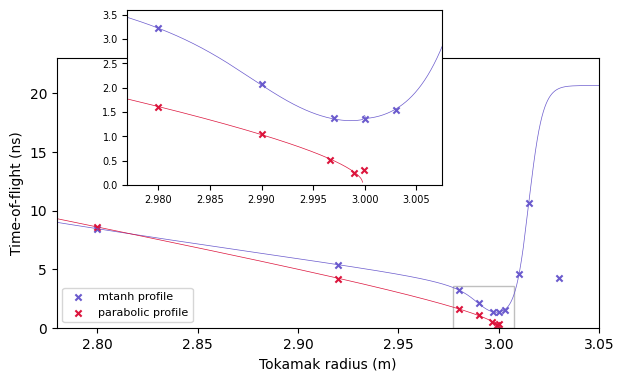

In [14]:
saveplots=0

fig,ax = plt.subplots(figsize=(7,3.5),dpi=100)

#img = plt.imread('tau_ini_mtanh.png')
#imgGraph = [[39,467],[121,845]]
#ax.imshow(img[imgGraph[0][0]:imgGraph[0][1],imgGraph[1][0]:imgGraph[1][1]], extent=[2.5,3.1,0,25], aspect='auto',alpha=0.1)

ax.scatter(Rc_[:len(df)],np.array(τfast_)[:len(df)]*Δt_Δx,marker='x',c='slateblue',s=20,label='mtanh profile')
ax.scatter(Rc_Parab[:len(dfParab)],(np.array(τfast_Parab)[:len(dfParab)])*Δt_Δx,marker='x',c='crimson',s=20,label='parabolic profile') #corrτ_parab

ax.plot(profileMtanh[0],profileMtanh[1]*1e9,c='slateblue',linewidth=0.5)
ax.plot(profileParab[0],profileParab[1]*1e9,c='crimson',linewidth=0.5)

ax.set_ylabel('Time-of-flight (ns)')
ax.set_xlabel('Tokamak radius (m)')

ax.set_ylim(0,23)
ax.set_xlim(2.78,3.05)

# Zoom
x1,x2 = (2.977,3.0075)
y1,y2 = (0,3.6)

axin = ax.inset_axes([0.13,0.53,0.58,0.65],xlim=(x1,x2),ylim=(y1,y2))
axin.scatter(Rc_[:len(df)],np.array(τfast_)[:len(df)]*Δt_Δx,marker='x',c='slateblue',s=20,label='mtanh profile')
axin.scatter(Rc_Parab[:len(dfParab)],(np.array(τfast_Parab)[:len(dfParab)])*Δt_Δx,marker='x',c='crimson',s=20,label='parabolic profile') #corrτ_parab
axin.plot(profileMtanh[0],profileMtanh[1]*1e9,c='slateblue',linewidth=0.5)
axin.plot(profileParab[0],profileParab[1]*1e9,c='crimson',linewidth=0.5)
axin.tick_params(labelsize=7)

ax.add_patch(Rectangle((x1,y1),x2-x1,y2-y1,edgecolor='gray',alpha=0.5,fill=False))

ax.legend(fontsize=8,loc='lower left')
if saveplots: plt.savefig(folderpath+'TOF_plot.png',bbox_inches='tight',transparent=True,dpi=500)

plt.show()